In [8]:
from pathlib import Path
from pqdm.processes import pqdm
import numpy as np
import matplotlib.pyplot as plt
import mne


mne.set_log_level(verbose='WARNING')

N_JOBS = 7  # Should match the number of your (high-performance) CPU cores

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
subjects = [
    '04', '06','07','08','09', '13','14','15','16','18','19',
    '20','21','22','23','24','25','26','27','28','29','30','32'
]

contrast = ['Cond == 2', 'Cond == 4']


def read_cleaned_epochs(subject):
    # Import epochs
    meg_subject_dir = Path(f'lb_analysis_sparse/import_metadata/sub-{subject}/meg/')
    filename = f'sub-{subject}_task-sparse_metadata_proc-clean_epo.fif'
    epochs_path = meg_subject_dir / filename

    epochs = mne.read_epochs(epochs_path)
    return epochs


def compute_evoked_contrast(subject):
    # Read epochs
    epochs = read_cleaned_epochs(subject)

    # Compute evokeds
    evokeds = [
        epochs[contrast[0]].average(),
        epochs[contrast[1]].average()
    ]

    # Contrast the evokeds
    evoked_contrast = mne.combine_evoked(evokeds, weights=[1, -1])

    return evoked_contrast


evoked_contrasts_all_subjects = pqdm(
    subjects,
    function=compute_evoked_contrast,
    n_jobs=1
)

print(f'Calculated {len(evoked_contrasts_all_subjects)} contrasts!')

  0%|          | 0/23 [00:00<?, ?it/s]

Calculated 23 contrasts!


In [4]:
ch_type = 'mag'  # we only use magnetometers – data was Maxwell-filtered
tmin = 0
tmax = None  # end of the evoked

all_evoked_contrasts_cropped = []
all_data = []

for evoked_contrast in evoked_contrasts_all_subjects:
    evoked_contrast_cropped = (
        evoked_contrast
        .copy()  # don't modify the original!
        .crop(tmin=tmin, tmax=tmax)
        .pick(ch_type)
    )
    all_evoked_contrasts_cropped.append(evoked_contrast_cropped)

    data = evoked_contrast_cropped.data.T  # transpose to have time on the first axis
    all_data.append(data)

    del evoked_contrast_cropped, data  # so we don't accidentally re-use it later!

all_data = np.array(all_data)

# get measurement info from first participant
info = all_evoked_contrasts_cropped[0].info
times = all_evoked_contrasts_cropped[0].times

# compute adjacency
adjacency, ch_names = mne.channels.find_ch_adjacency(info=info, ch_type=ch_type)

all_data.shape, adjacency.shape, times.shape

((23, 32, 102), (102, 102), (32,))

In [5]:
all_data[0].shape

(32, 102)

In [42]:
from mne.stats import permutation_cluster_1samp_test, spatio_temporal_cluster_1samp_test

# n_permutations = 2**12
n_permutations = 2**13
# n_permutations = 'all'
tail = 0
threshold = None

cluster_stats = spatio_temporal_cluster_1samp_test(
    X=all_data,
    threshold=threshold,
    n_jobs=N_JOBS,
    tail=tail,
    n_permutations=n_permutations,
    adjacency=adjacency,
    out_type='mask',
    seed=42,  # make results reproducible
    verbose=True,
)

T_obs, clusters, p_values, _ = cluster_stats

Using a threshold of 2.073873
stat_fun(H1): min=-3.585704 max=4.689721
Running initial clustering
Found 27 clusters
Permuting 8191 times...


  0%|          |  : 0/8191 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [43]:
len(clusters)

27

In [44]:
len(p_values)

27

In [45]:
p_threshold = 0.05
significant_clusters_indices = np.where(p_values < p_threshold)[0]  # don't forget the [0]
significant_clusters_indices

array([5])

In [46]:
significant_clusters = []

for cluster_index in significant_clusters_indices:
    significant_clusters.append(clusters[cluster_index])

significant_clusters

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])]

In [50]:
significant_clusters[0].shape

(32, 102)

In [54]:
import pandas as pd

cluster_df = pd.DataFrame(
    significant_clusters[0],
    columns=all_evoked_contrasts_cropped[0].ch_names,
    index=pd.Index(times, name='time')
)
cluster_df.to_clipboard()

Text(0, 0.5, 'T-value')

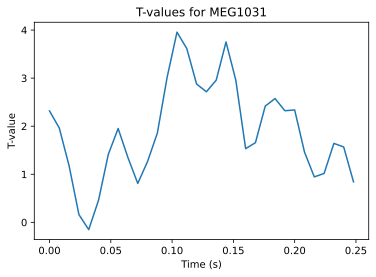

In [61]:
ch_name = 'MEG1031'
ch_idx = (
    all_evoked_contrasts_cropped[0]
    .ch_names
    .index(ch_name)
)

fig, ax = plt.subplots()
ax.plot(times, T_obs[:, ch_idx])
ax.set_title(f'T-values for {ch_name}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('T-value')

In [10]:
import stat_func

cluster_info = stat_func.extract_info_cluster(
    cluster_stats=cluster_stats,
    p_threshold=p_threshold,
    times=times,
    info=info,
    data_array_chtype=all_data,
    ch_type=ch_type
)

We found 102 positions for ch_type mag


Saving _clust_1.svg


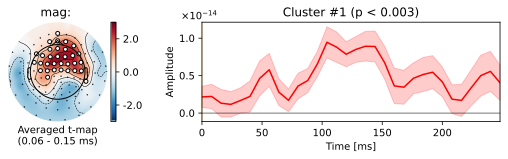

True

In [11]:

stat_func.plot_clusters(
    cluster_info, ch_type, T_obs_max=3., fname='', figname_initial='',
    filter_smooth=False, outfile=None)